# Informes y predicciones de COVID-19 en España 

Actualizado diariamente, este documento se [visualiza mejor aquí](https://nbviewer.jupyter.org/github/jaimevalero/COVID-19/blob/master/jupyter/Pain_Graphs.ipynb).

**Indice**

## [1. Datos de Madrid, hoy](#DatosMadrid)

## 2. Comparativas y predicciones

| Comparativas de dos dimensiones | Comparativas por comunidades  | Comparativas individuales | Predicciones |
| --- | --- | --- |  --- | 
| [Casos Vs fallecidos, historicos](#Comparativa_Casos_Fallecidos) | [Comparativa de fallecidos](#Comunidades_Fallecidos) | [Fallecidos hoy, en España](#Pico_España) | [Predicción de fallecidos, en España](#Prediccion_Fallecidos_España)|
| [Casos Vs fallecidos, hoy](#Comparativa_Casos_Fallecidos_Hoy) |   [Comparativa de fallecidos, hoy](#Comunidades_Fallecidos_Hoy) | [Fallecidos hoy, en Madrid](#Reporte_Fallecidos_hoy_absoluto_Madrid)|  [Predicción de fallecidos, en Madrid](#Prediccion_Fallecidos_hoy_absoluto_Madrid)
| [Casos Vs fallecidos, variación diaria](#Comparativa_Casos_Fallecidos_Variacion_Diaria) |[Comparativa de mortalidad](#Comunidades_Mortalidad)| [Fallecidos hoy, en Cataluña](#Reporte_Fallecidos_hoy_absoluto_Cataluña)|  [Predicción de fallecidos, en Cataluña](#Prediccion_Fallecidos_hoy_absoluto_Cataluña)
|  |  [Comparativa de curados](#Curados)| [Fallecidos hoy, en Castilla y León](#Reporte_Fallecidos_hoy_absoluto_CyL)|[Predicción de fallecidos, en Castilla y León](#Prediccion_Fallecidos_hoy_absoluto_CyL)
|  | | [Fallecidos hoy, en Castilla La Mancha](#Reporte_Fallecidos_hoy_absoluto_CM) |[Predicción de fallecidos, en Castilla La Mancha](#Prediccion_Fallecidos_hoy_absoluto_CM)
|  |  | | |
  



## [3. ¿ Son reales estos datos ?](#Reales)




In [1]:
# Cargamos datos
import Loading_data 
from matplotlib import pyplot as plt    
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML

def Insertar_Enlace(cell_name):
    display(HTML('<a id="'+ cell_name +'"></a>'))

Insertar_Enlace('DatosMadrid')

COMUNIDAD_A_CONSIDERAR = 'Madrid'
comunidad = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)
comunidad.head(10)




,Lugar,Casos,Casos hoy absoluto,Casos hoy variacion respecto ayer,Casos hoy porcentaje,Fallecidos,Fallecidos hoy absoluto,Fallecidos hoy variacion respecto ayer,Fallecidos hoy porcentaje,Tasa Mortalidad,Curados,Curados hoy absoluto,Casos excluidos curados,Proporcion Curados hoy absoluto / Casos hoy absoluto,UCI,Hospitalizados
Fecha,,,,,,,,,,,,,,,,
2020-05-11,Madrid,64853,66,-198,0.001018,8683,39,-7,0.004492,0.133887,39604,75.0,25249,1.136364,3529,41650
2020-05-10,Madrid,64787,264,74,0.004075,8644,46,0,0.005322,0.133422,39529,302.0,25258,1.143939,3520,41559
2020-05-09,Madrid,64523,190,-273,0.002945,8598,46,-2,0.005350,0.133255,39227,252.0,25296,1.326316,3508,41436
2020-05-08,Madrid,64333,463,9,0.007197,8552,48,10,0.005613,0.132933,38975,305.0,25358,0.658747,3493,41304
2020-05-07,Madrid,63870,454,27,0.007108,8504,38,-8,0.004468,0.133145,38670,339.0,25200,0.746696,3485,41159
2020-05-06,Madrid,63416,427,-167,0.006733,8466,46,2,0.005433,0.133499,38331,329.0,25085,0.770492,3465,41031
2020-05-05,Madrid,62989,594,404,0.009430,8420,44,0,0.005226,0.133674,38002,194.0,24987,0.326599,3442,40851
2020-05-04,Madrid,62395,190,58,0.003045,8376,44,4,0.005253,0.134242,37808,104.0,24587,0.547368,3431,40741
2020-05-03,Madrid,62205,132,-112,0.002122,8332,40,-30,0.004801,0.133944,37704,174.0,24501,1.318182,3421,40597


In [2]:
import pandas as pd


def Get_Dimensions_All_CCAA(Atributos,media_movil ):
    array = []
    dias_a_considerar = 4 if media_movil else 1
    for ca in COMUNIDADES: 
        
        comunidad = Loading_data.Get_Comunidad(ca).head(dias_a_considerar)
        comunidad = comunidad.reset_index() # Resets the index, makes factor a column
        if media_movil : comunidad = pd.DataFrame(comunidad.mean(axis=0)).T 
        temp_dict = {}
        temp_dict['Lugar'] = ca
        for attr in Atributos:
            temp_dict[attr] = comunidad[attr].iloc[0]
        array.append(temp_dict)

    return pd.DataFrame.from_records(array)



In [3]:
import scipy.stats as spstats
from matplotlib import pyplot as plt    


def Print_Two_Cordinates_CCAA(df, add_LR=False):
    fig,ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(8)
    ax.axhline(y=0, color='blue')
    ax.axvline(x=0, color='blue')

    for k,d in df.groupby('Lugar'):
        ax.scatter(d[df.columns[1]], d[df.columns[2]], label=k)

    plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
    
    if add_LR:
        slope, intercept, r_value, p_value, std_err = spstats.linregress(df[df.columns[1]], df[df.columns[2]])
        plt.plot(df[df.columns[1]], intercept + slope*df[df.columns[1]], 'r', label='fitted line')
        #.format(round(slope, 2),round(intercept, 2),round(r_value, 2))
        note2add = f"""slope: {slope:12.4f}\nintercept: {intercept:8.2f}\nr2: {r_value**2:15.4f}"""
        plt.annotate(note2add,xy=(0.7,0.3), xycoords='figure fraction')
        
    ax.set_xlabel(df.columns[1])
    ax.set_ylabel(df.columns[2])
    ax.set_title(df.columns[1]+ ' VS. ' + df.columns[2])
    
    return plt


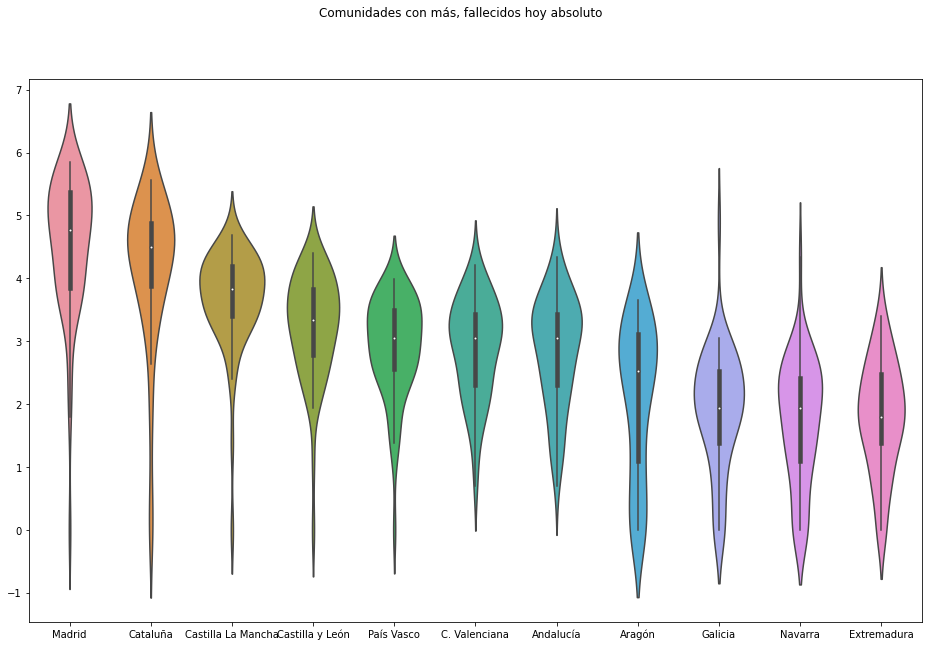

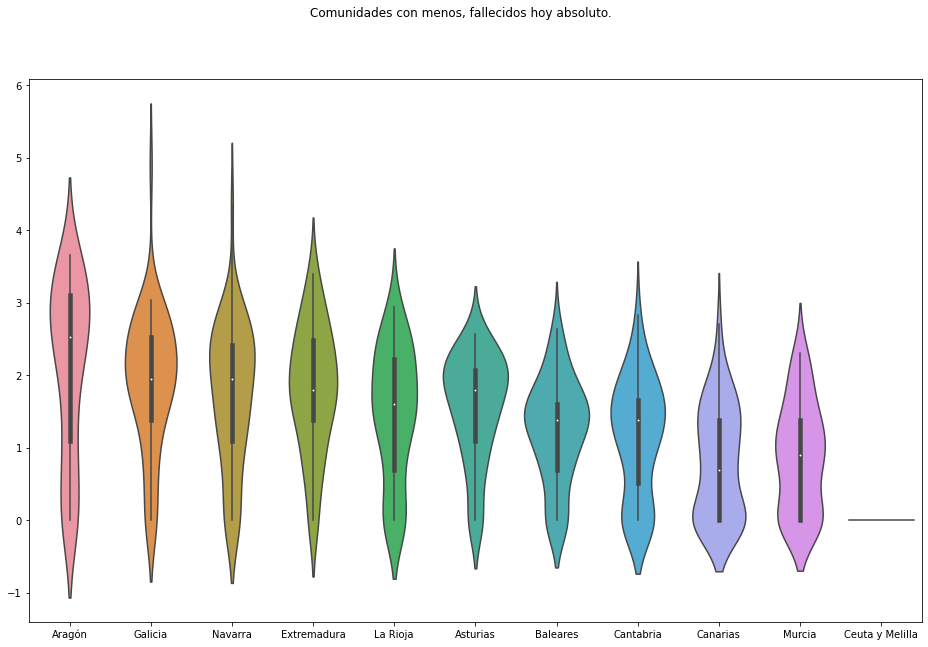

In [4]:
import numpy as np 
import seaborn as sns

from Loading_data import Get_Comunidades_List as comunidades
COMUNIDADES = comunidades()

def Get_Single_Dimension(dimension ):
    df = pd.DataFrame()
    df_tmp = pd.DataFrame()
    array = []
    #
    for ca in COMUNIDADES:
        df_tmp = Loading_data.Get_Comunidad(ca)
        new = df_tmp[[dimension]].copy()
        new.rename(columns={dimension: ca}, inplace=True)
        array.append(new)
    #
    df =  pd.concat(array, axis=1)
    return df

def plot_violin(dimension):
    """ Muestra la distribucion logaritmica por comunidades, de una dimension"""
    df = Get_Single_Dimension(dimension) 
    # Ordenamos comunidades 
    s = df.sum()
    df = df[s.sort_values(ascending=False).index[:]]

    # Pasamos a logaritmo
    df2 = np.log(df)
    df2.replace(-np.inf,  np.nan, inplace=True)
    display(HTML("<h2>Comparativa de distribucion de '" +dimension+ "', en cada CC.AA </h2>"))
    display(HTML("Distribuciones convertidas a logaritmos neperianos, para facilitar la comparación."))

    # primer grafico
    f, ax = plt.subplots()
    f.set_size_inches( 16, 10)
    f.suptitle("Comunidades con más, " + dimension.lower())
    sns.violinplot(data=df2.iloc[:,:-7])

    #segundo grafico
    f, ax = plt.subplots()
    f.set_size_inches( 16, 10)
    f.suptitle("Comunidades con menos, " + dimension.lower()+".")
    sns.violinplot(data=df2.iloc[:,7:])
    return df

dimension = 'Fallecidos hoy absoluto'
df = plot_violin(dimension)


In [5]:
df

,Madrid,Cataluña,Castilla La Mancha,Castilla y León,País Vasco,C. Valenciana,Andalucía,Aragón,Galicia,Navarra,Extremadura,La Rioja,Asturias,Baleares,Cantabria,Canarias,Murcia,Ceuta y Melilla
Fecha,,,,,,,,,,,,,,,,,,
2020-05-11,39,23,27,8,5,7,2,1,1,2,3,0,4,0,0,1,0,0
2020-05-10,46,25,21,12,15,8,3,1,1,1,3,2,2,2,0,0,1,0
2020-05-09,46,36,25,9,13,6,16,8,3,3,5,2,1,5,0,0,1,0
2020-05-08,48,77,36,12,7,6,7,15,2,4,5,4,0,1,1,4,0,0
2020-05-07,38,49,30,17,19,12,13,12,4,4,4,1,5,2,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-11,10,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
2020-03-10,13,2,0,0,1,0,0,2,0,0,0,1,0,0,0,0,0,0
2020-03-09,6,1,0,0,5,0,0,0,0,0,0,-1,0,0,0,0,0,0


In [6]:


import Loading_data 

from Loading_data import Get_Comunidades_List as comunidades
COMUNIDADES = comunidades()

def Comparar_Dos_Dimensiones(Atributos, media_movil=False, add_LR=False ):
    """ Compara dos dimensiones de atributos, Ma indica si hacerlo con la media movil"""
    
    df = Get_Dimensions_All_CCAA(Atributos,media_movil )
    df = df.sort_values(by=[df.columns[1],df.columns[2]])
    plt = Print_Two_Cordinates_CCAA(df, add_LR)
    plt.show()
    print(  'Total: '  + df.columns[1], df[df.columns[1]].sum() )
    print(  'Total: '  + df.columns[2], df[df.columns[2]].sum() )
    display(HTML(df.set_index('Lugar').to_html(index=True)))
    return 

  

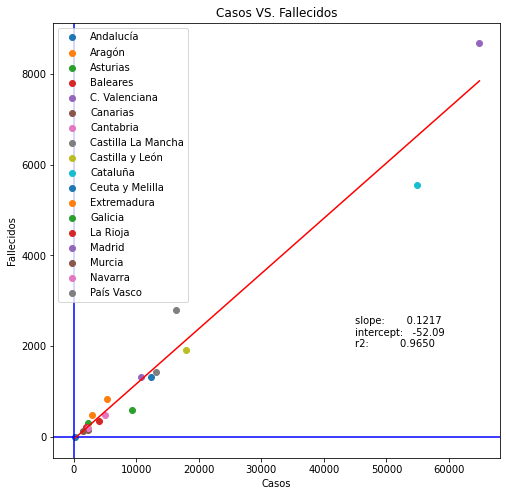

Total: Casos 227436
Total: Fallecidos 26744


,Casos,Fallecidos
Lugar,,
Ceuta y Melilla,229,6
Murcia,1517,139
Baleares,1953,209
Cantabria,2245,201
Canarias,2260,149
Asturias,2346,299
Extremadura,2918,483
La Rioja,4008,346
Navarra,5065,490


In [7]:
Insertar_Enlace("Comparativa_Casos_Fallecidos")
Comparar_Dos_Dimensiones(['Casos', 'Fallecidos'],add_LR=True )  


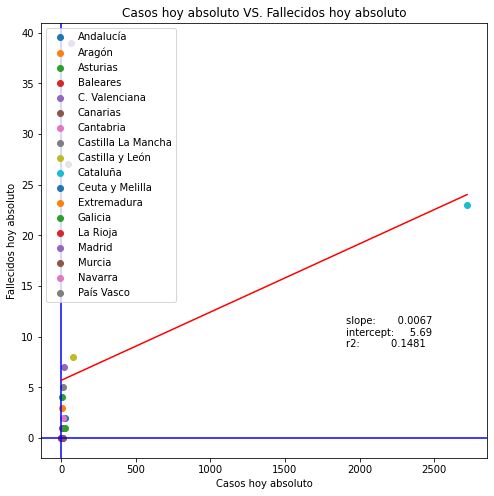

Total: Casos hoy absoluto 3046
Total: Fallecidos hoy absoluto 123


,Casos hoy absoluto,Fallecidos hoy absoluto
Lugar,,
Ceuta y Melilla,0,0
La Rioja,0,0
Cantabria,1,0
Canarias,2,1
Baleares,3,0
Asturias,3,4
Extremadura,6,3
Murcia,9,0
País Vasco,11,5


In [8]:
Insertar_Enlace("Comparativa_Casos_Fallecidos_Hoy")

Comparar_Dos_Dimensiones(['Casos hoy absoluto', 'Fallecidos hoy absoluto'],add_LR=True )   

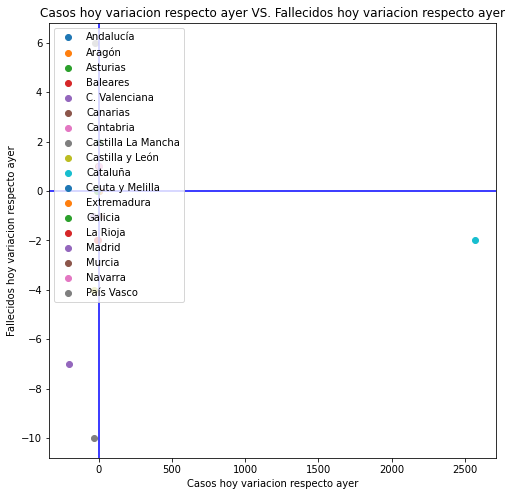

Total: Casos hoy variacion respecto ayer 2234
Total: Fallecidos hoy variacion respecto ayer -20


,Casos hoy variacion respecto ayer,Fallecidos hoy variacion respecto ayer
Lugar,,
Madrid,-198,-7
C. Valenciana,-36,-1
País Vasco,-34,-10
Castilla y León,-32,-4
Castilla La Mancha,-21,6
Galicia,-10,0
La Rioja,-8,-2
Canarias,-6,1
Aragón,-5,0


In [9]:
Insertar_Enlace("Comparativa_Casos_Fallecidos_Variacion_Diaria")

Comparar_Dos_Dimensiones(['Casos hoy variacion respecto ayer', 'Fallecidos hoy variacion respecto ayer'])

In [10]:
# Cargamos datos
import pandas as pd
import Loading_data 

from Loading_data import Get_Comunidades_List as comunidades
COMUNIDADES = comunidades()

def Get_Dimension_CCAA(Dimension,include_nation=False):
    def Do_Stuff_to_DF(df):
        df = df.sort_values(by='Fecha')
        # df = df.reset_index() # Resets the index, makes factor a column    
        df = df[df["Casos"] >= 100]
        return df
        
    dimension_df = pd.DataFrame()
    for ca in COMUNIDADES: 
        df = Loading_data.Get_Comunidad(ca)
        df = Do_Stuff_to_DF(df)
        dimension_df[ca] = df[Dimension]
    if include_nation:
        df = Loading_data.Get_Nacion()
        df = Do_Stuff_to_DF(df)
        dimension_df['TOTAL'] = df[Dimension]
        
    return dimension_df 


In [11]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display, HTML
import pandas as pd

import numpy as np


def compare_charts_median(Dimension,df): 
    short_df = df.tail(1)
    short_df = short_df.T
    short_df = short_df.sort_values(by=(short_df.columns[0]))
    short_df.columns = [Dimension]

    #mean_y = short_df.median(axis=1)[0]
    #mean_y= df.tail(1).T.median().values[0]
    median_y= df.tail(1).T.drop(axis=0,labels=(['TOTAL'] if 'TOTAL' in short_df.index else [])).median().values[0]
    x = short_df.index
    y = short_df[Dimension]

    plt.figure(figsize = (10, 5))
    plt.scatter(x, y, c= "red", alpha = 0.5)
    plt.title(Dimension + " by region")
    color = 'blue'
    plt.xticks(rotation=90)
    plt.axhline(median_y, c = color, alpha = 0.5, lw = 1)
    plt.annotate('Median ' + Dimension+  ' is {}'.format(round(median_y, 2)),
            xy=(8.5, median_y),
            xycoords='data',
            xytext=(-50, 50), 
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color = "k", alpha = 0.5),
            color = color)
    return

def compare_charts_time(Dimension,df):
    fig = plt.figure(figsize=(8, 6), dpi=80)
    for ca in df.columns:
        plt.plot(df[ca])
    plt.legend(df.columns)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))

    fig.suptitle('Comparativa de: '+Dimension, fontsize=20)
    plt.show()
    return 

def Report_Location(Dimension,include_nation=False):
    # Ger Data
    df = Get_Dimension_CCAA(Dimension,include_nation)
    # Compare chart
    compare_charts_time(Dimension,df)
    # Compare median chart
    compare_charts_median(Dimension,df)
    
    with pd.option_context("display.max_rows", 1000):
        display(HTML(df.to_html()))
    return 

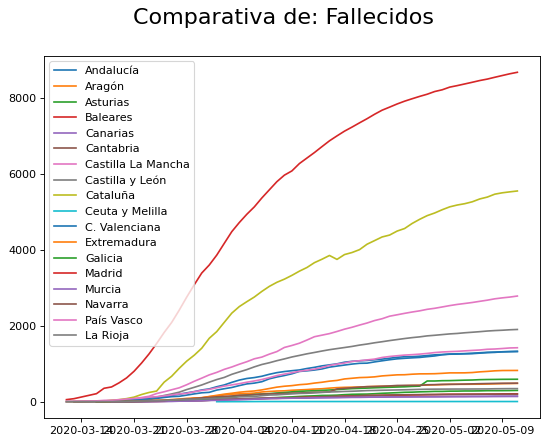

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
Fecha,,,,,,,,,,,,,,,,,,
2020-03-12,0,NaN,NaN,NaN,NaN,NaN,1,NaN,4,NaN,NaN,NaN,NaN,56,NaN,NaN,11,2
2020-03-13,0,NaN,NaN,NaN,NaN,NaN,5,1.0,4,NaN,NaN,NaN,NaN,81,NaN,0.0,14,2
2020-03-16,7,11.0,1.0,NaN,1.0,NaN,17,9.0,12,NaN,5.0,2.0,2.0,213,NaN,1.0,23,4
2020-03-17,11,12.0,1.0,NaN,2.0,NaN,17,12.0,18,NaN,13.0,3.0,3.0,355,NaN,2.0,36,5
2020-03-18,19,13.0,1.0,1.0,3.0,NaN,28,22.0,41,NaN,22.0,6.0,3.0,390,0.0,3.0,40,5
2020-03-19,23,15.0,1.0,2.0,3.0,NaN,42,29.0,55,NaN,24.0,8.0,4.0,498,0.0,4.0,53,5
2020-03-20,30,17.0,2.0,2.0,4.0,1.0,62,43.0,82,NaN,33.0,10.0,5.0,628,0.0,5.0,71,7
2020-03-21,40,22.0,5.0,4.0,7.0,2.0,84,55.0,122,NaN,50.0,12.0,9.0,804,1.0,9.0,85,15
2020-03-22,47,24.0,8.0,4.0,9.0,5.0,112,74.0,191,NaN,69.0,14.0,12.0,1021,1.0,14.0,97,18


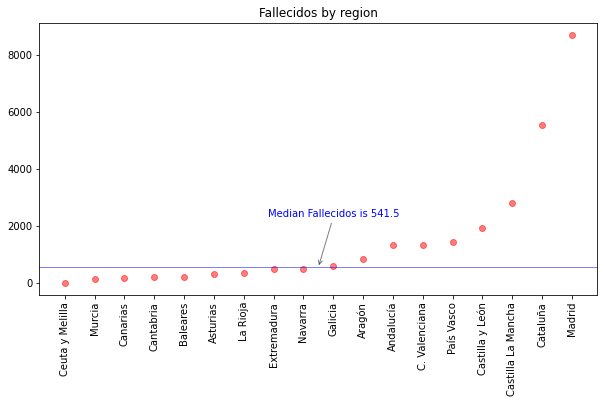

In [12]:
Insertar_Enlace("Comunidades_Fallecidos")
Report_Location("Fallecidos")

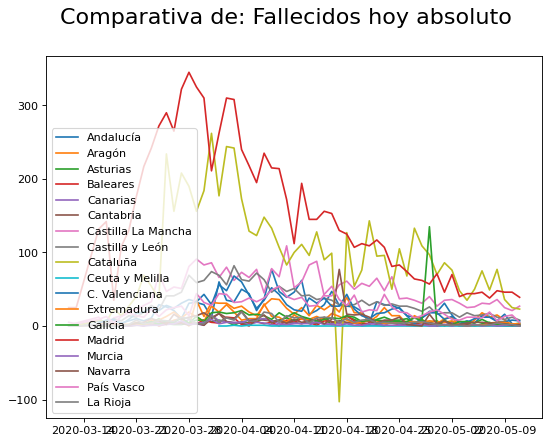

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
Fecha,,,,,,,,,,,,,,,,,,
2020-03-12,0,NaN,NaN,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN,25,NaN,NaN,5,0
2020-03-13,0,NaN,NaN,NaN,NaN,NaN,4,1.0,0,NaN,NaN,NaN,NaN,25,NaN,0.0,3,0
2020-03-16,7,4.0,0.0,NaN,1.0,NaN,12,8.0,8,NaN,4.0,1.0,2.0,132,NaN,1.0,9,2
2020-03-17,4,1.0,0.0,NaN,1.0,NaN,0,3.0,6,NaN,8.0,1.0,1.0,142,NaN,1.0,13,1
2020-03-18,8,1.0,0.0,0.0,1.0,NaN,11,10.0,23,NaN,9.0,3.0,0.0,35,0.0,1.0,4,0
2020-03-19,4,2.0,0.0,1.0,0.0,NaN,14,7.0,14,NaN,2.0,2.0,1.0,108,0.0,1.0,13,0
2020-03-20,7,2.0,1.0,0.0,1.0,0.0,20,14.0,27,NaN,9.0,2.0,1.0,130,0.0,1.0,18,2
2020-03-21,10,5.0,3.0,2.0,3.0,1.0,22,12.0,40,NaN,17.0,2.0,4.0,176,1.0,4.0,14,8
2020-03-22,7,2.0,3.0,0.0,2.0,3.0,28,19.0,69,NaN,19.0,2.0,3.0,217,0.0,5.0,12,3


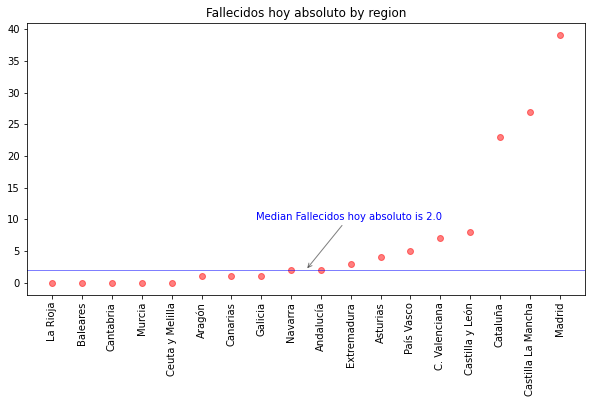

In [13]:
Insertar_Enlace("Comunidades_Fallecidos_Hoy")

Report_Location("Fallecidos hoy absoluto") 

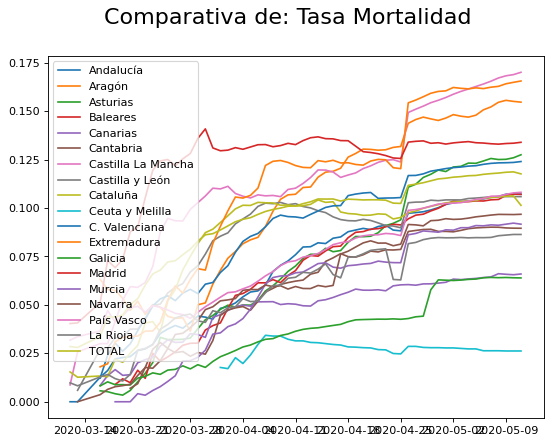

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja,TOTAL
Fecha,,,,,,,,,,,,,,,,,,,
2020-03-12,0.000000,NaN,NaN,NaN,NaN,NaN,0.008696,NaN,0.015385,NaN,NaN,NaN,NaN,0.040346,NaN,NaN,0.031792,0.009756,0.028475
2020-03-13,0.000000,NaN,NaN,NaN,NaN,NaN,0.025773,0.005917,0.012658,NaN,NaN,NaN,NaN,0.040704,NaN,0.000000,0.033573,0.008230,0.028035
2020-03-16,0.012635,0.063218,0.005650,NaN,0.008403,NaN,0.029982,0.026946,0.013289,NaN,0.012225,0.018018,0.008163,0.051140,NaN,0.003650,0.036508,0.012821,0.033620
2020-03-17,0.016105,0.057971,0.005181,NaN,0.013514,NaN,0.029982,0.027842,0.012912,NaN,0.024030,0.019608,0.010274,0.072880,NaN,0.006390,0.047059,0.014085,0.043926
2020-03-18,0.022119,0.057522,0.004132,0.008929,0.016575,NaN,0.041481,0.032934,0.021972,NaN,0.030303,0.030928,0.008798,0.069186,0.000000,0.007772,0.041110,0.011933,0.043599
2020-03-19,0.022817,0.053381,0.003425,0.011834,0.013636,NaN,0.052434,0.033410,0.020355,NaN,0.026059,0.033195,0.008830,0.073484,0.000000,0.008299,0.044538,0.010684,0.044731
2020-03-20,0.023310,0.047222,0.005814,0.009852,0.013937,0.006944,0.059387,0.037489,0.025076,NaN,0.029864,0.033670,0.008651,0.087648,0.000000,0.009025,0.048464,0.014085,0.050150
2020-03-21,0.026403,0.051887,0.010288,0.016260,0.020115,0.009302,0.059030,0.037517,0.029027,NaN,0.036684,0.033898,0.012179,0.090124,0.004167,0.013554,0.049275,0.026596,0.053197
2020-03-22,0.027246,0.045113,0.014679,0.012085,0.021739,0.017730,0.061572,0.042431,0.040604,NaN,0.043017,0.036458,0.013115,0.105236,0.003378,0.017632,0.046257,0.027523,0.060199


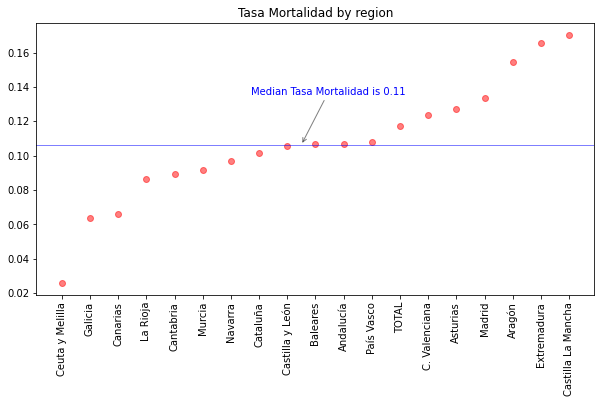

In [14]:
Insertar_Enlace("Comunidades_Mortalidad")

Report_Location("Tasa Mortalidad",True)

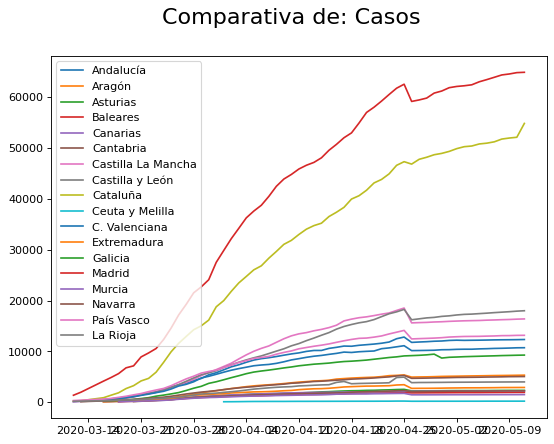

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
Fecha,,,,,,,,,,,,,,,,,,
2020-03-12,115,NaN,NaN,NaN,NaN,NaN,115,NaN,260,NaN,NaN,NaN,NaN,1388,NaN,NaN,346,205
2020-03-13,219,NaN,NaN,NaN,NaN,NaN,194,169.0,316,NaN,NaN,NaN,NaN,1990,NaN,130.0,417,243
2020-03-16,554,174.0,177.0,NaN,119.0,NaN,567,334.0,903,NaN,409.0,111.0,245.0,4165,NaN,274.0,630,312
2020-03-17,683,207.0,193.0,NaN,148.0,NaN,567,431.0,1394,NaN,541.0,153.0,292.0,4871,NaN,313.0,765,355
2020-03-18,859,226.0,242.0,112.0,181.0,NaN,675,668.0,1866,NaN,726.0,194.0,341.0,5637,122.0,386.0,973,419
2020-03-19,1008,281.0,292.0,169.0,220.0,NaN,801,868.0,2702,NaN,921.0,241.0,453.0,6777,167.0,482.0,1190,468
2020-03-20,1287,360.0,344.0,203.0,287.0,144.0,1044,1147.0,3270,NaN,1105.0,297.0,578.0,7165,204.0,554.0,1465,497
2020-03-21,1515,424.0,486.0,246.0,348.0,215.0,1423,1466.0,4203,NaN,1363.0,354.0,739.0,8921,240.0,664.0,1725,564
2020-03-22,1725,532.0,545.0,331.0,414.0,282.0,1819,1744.0,4704,NaN,1604.0,384.0,915.0,9702,296.0,794.0,2097,654


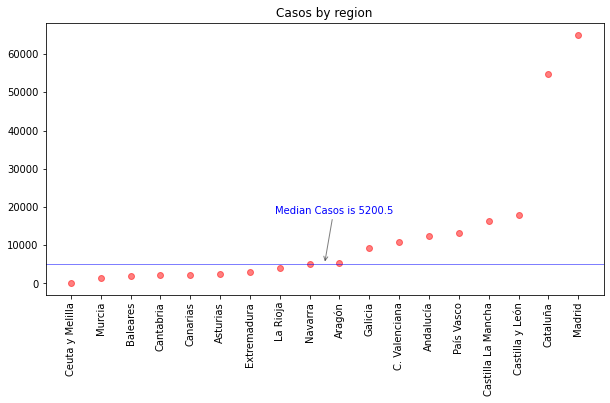

In [15]:
Insertar_Enlace("Comunidades_Casos")

Report_Location("Casos") 

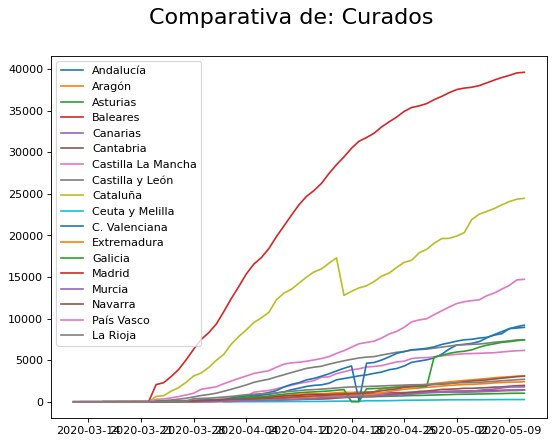

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
Fecha,,,,,,,,,,,,,,,,,,
2020-03-12,0,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0
2020-03-13,0,NaN,NaN,NaN,NaN,NaN,0,0.0,0,NaN,NaN,NaN,NaN,0,NaN,0.0,0,0
2020-03-16,0,0.0,0.0,NaN,0.0,NaN,0,0.0,0,NaN,0.0,0.0,0.0,0,NaN,0.0,0,0
2020-03-17,0,0.0,0.0,NaN,0.0,NaN,0,0.0,0,NaN,0.0,0.0,0.0,0,NaN,0.0,0,0
2020-03-18,0,0.0,0.0,0.0,0.0,NaN,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0
2020-03-19,0,0.0,0.0,0.0,0.0,NaN,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0
2020-03-20,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0
2020-03-21,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0
2020-03-22,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0


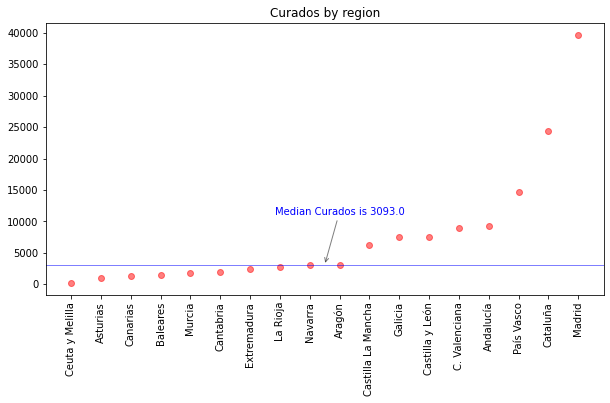

In [16]:
Insertar_Enlace("Curados")

Report_Location("Curados")

## ¿Hemos alcanzado el pico de la curva?


### Casos totales españa, evolucion


,Total Fallecidos,Total Fallecidos hoy absoluto,MA Total Fallecidos hoy absoluto,Variacion MA Total Fallecidos hoy absoluto
Fecha,,,,
2020-03-12,74,NaN,NaN,NaN
2020-03-13,107,33.0,NaN,NaN
2020-03-16,308,201.0,NaN,NaN
2020-03-17,490,182.0,NaN,NaN
2020-03-18,597,107.0,130.75,NaN
2020-03-19,766,169.0,164.75,34.00
2020-03-20,1002,236.0,173.50,8.75
2020-03-21,1326,324.0,209.00,35.50
2020-03-22,1720,394.0,280.75,71.75


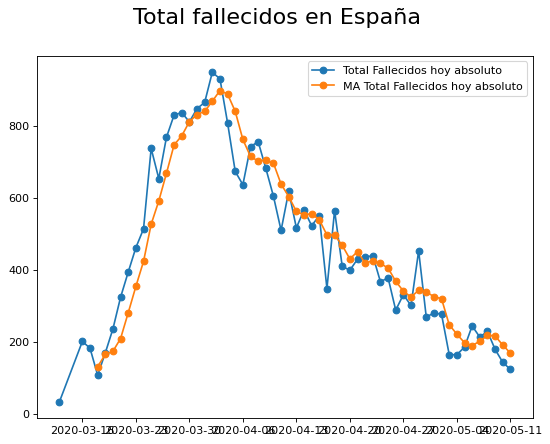

In [17]:
# Casos totales españa, evolucion
import Loading_data 

MOVING_AVERAGE_WINDOW=4

def get_fallecidos_nacion(window_size=MOVING_AVERAGE_WINDOW):
    Dimension = 'Fallecidos'
    
    Insertar_Enlace("Pico_España")

    df = Get_Dimension_CCAA(Dimension)

    df['Total Fallecidos'] = df.sum(axis=1)
    df['Total Fallecidos']

    CONVERT_INT_COLUMNS = ['Total Fallecidos']
    for column in CONVERT_INT_COLUMNS :
        df[column] = df[column].fillna(0)
        df[column] = df[column].astype(np.int64)

    df['Total Fallecidos hoy absoluto'] = df['Total Fallecidos'] - df['Total Fallecidos'].shift(1)
    df['MA Total Fallecidos hoy absoluto'] = df['Total Fallecidos hoy absoluto'].rolling(window=window_size).mean()

    df['Variacion MA Total Fallecidos hoy absoluto'] = df['MA Total Fallecidos hoy absoluto'] - df['MA Total Fallecidos hoy absoluto'].shift(1)
    return df

df = get_fallecidos_nacion()
df_plt = df[['Total Fallecidos hoy absoluto','MA Total Fallecidos hoy absoluto']]
fig = plt.figure(figsize=(8, 6), dpi=80)
plt.plot(df_plt, marker='o') 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.legend(df_plt.columns)
fig.suptitle( "Total fallecidos en España", fontsize=20)

df[['Total Fallecidos',
    'Total Fallecidos hoy absoluto',
    'MA Total Fallecidos hoy absoluto',
    'Variacion MA Total Fallecidos hoy absoluto']]



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1,2020-03-16,125.621374,18.114939,173.126260,125.621374,125.621374,-27.654515,-27.654515,-27.654515,-27.654515,-27.654515,-27.654515,0.0,0.0,0.0,97.966859
2,2020-03-17,177.584316,94.162508,250.341428,177.584316,177.584316,-5.102069,-5.102069,-5.102069,-5.102069,-5.102069,-5.102069,0.0,0.0,0.0,172.482247
3,2020-03-18,229.547258,187.669384,340.783886,229.547258,229.547258,39.261312,39.261312,39.261312,39.261312,39.261312,39.261312,0.0,0.0,0.0,268.808570
4,2020-03-19,281.510200,221.419009,371.551398,281.510200,281.510200,15.247593,15.247593,15.247593,15.247593,15.247593,15.247593,0.0,0.0,0.0,296.757793
5,2020-03-20,333.473142,255.818845,413.061555,333.473142,333.473142,3.016228,3.016228,3.016228,3.016228,3.016228,3.016228,0.0,0.0,0.0,336.489370
6,2020-03-21,385.436084,320.070136,474.752527,385.436084,385.436084,8.972117,8.972117,8.972117,8.972117,8.972117,8.972117,0.0,0.0,0.0,394.408202
7,2020-03-22,437.399026,327.766653,483.488789,437.399026,437.399026,-33.740666,-33.740666,-33.740666,-33.740666,-33.740666,-33.740666,0.0,0.0,0.0,403.658360
8,2020-03-23,489.361968,381.844988,542.096459,489.361968,489.361968,-27.654515,-27.654515,-27.654515,-27.654515,-27.654515,-27.654515,0.0,0.0,0.0,461.707453
9,2020-03-24,541.324910,456.216878,618.503391,541.324910,541.324910,-5.102069,-5.102069,-5.102069,-5.102069,-5.102069,-5.102069,0.0,0.0,0.0,536.222841
10,2020-03-25,593.287852,553.768240,713.636643,593.287852,593.287852,39.261312,39.261312,39.261312,39.261312,39.261312,39.261312,0.0,0.0,0.0,632.549164


Prediccion total para Total Fallecidos hoy absoluto : 27077.63388690514


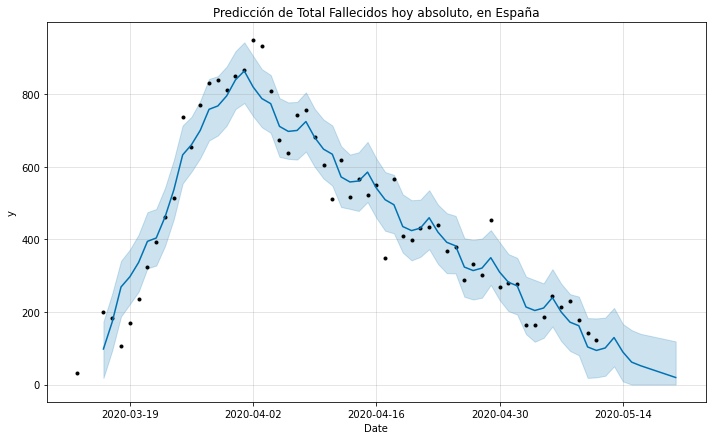

In [18]:
import fbprophet
def Get_Prediction_Nacion(df,dimension,location='España' , link=None) :
    df = df[[dimension]]
    df = df[df[dimension] > 0]

    df = df.dropna()
    df = df.reset_index()
    df.columns = ['ds','y']


    df_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
    df_prophet.fit(df)

    # Make a future dataframe for 2 years
    df_forecast = df_prophet.make_future_dataframe(periods=45, freq='D')
    # Make predictions
    df_forecast = df_prophet.predict(df_forecast)
    df_forecast

    df_forecast = df_forecast[df_forecast["yhat"] >= 0]
    df_forecast.loc[df_forecast.yhat_lower < 0, 'yhat_lower'] = 0
    
    if link is not None:
        Insertar_Enlace(link)

    df_prophet.plot(df_forecast, xlabel = 'Date' )
    plt.title('Predicción de ' + dimension + ", en " + location )

    suma = df_forecast.trend.sum()
    display(HTML(pd.DataFrame(df_forecast).to_html()))

    print ("Prediccion total para " + dimension + " : " + str(suma) )
    return df_forecast
    
    
Insertar_Enlace("Prediccion_Fallecidos_España")
    
prediccion = Get_Prediction_Nacion( df = get_fallecidos_nacion(), 
                                   dimension = 'Total Fallecidos hoy absoluto')

In [19]:
def Get_Predictions_Compare(df,dimension,location='España' , link=None) :
    if link is not None:
        Insertar_Enlace(link)


    display(HTML("<h2>Comparativa de predicciones, hoy contra días pasados, " +dimension+ " en " +  location+ "</h2>"))

        
    df = df[[dimension]]
    df = df[df[dimension] > 0]

    df = df.dropna()
    df = df.reset_index()

    df.columns = ['ds','y']
    
    df_original = df.copy()

    
    results = pd.DataFrame()
    array_results_temp = []
    for i in range(4):
        
        if i >= 1 : df = df.iloc[1:]
    
        fecha=max(df.ds)
        fecha_short = str(fecha)[:10]
        

        df_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
        df_prophet.fit(df)

        # Make a future dataframe 
        df_forecast = df_prophet.make_future_dataframe(periods=45, freq='D')
        # Make predictions
        df_forecast = df_prophet.predict(df_forecast)
        suma = df_forecast.yhat.sum()
            
        title_column = "Predicción con los datos de " + fecha_short
        df_forecast[title_column] = df_forecast.yhat
        
        array_results_temp.append(pd.DataFrame(df_forecast[['ds',title_column]]))


    df_1 = pd.merge(array_results_temp[0], array_results_temp[1], how ='outer', on ='ds') 
    df_2 = pd.merge(df_1                 , array_results_temp[2], how ='outer', on ='ds') 
    df_3 = pd.merge(df_2                 , array_results_temp[3], how ='outer', on ='ds') 
    df_4 = pd.merge(df_3                 , df_original          , how ='outer', on ='ds') 
    df_4['datos reales'] = df_4['y']
    del df_4['y']

        
    df_chart = df_4
    df_chart = df_chart.set_index('ds')
    df_chart = df_chart.head(70).tail(40)

    for c in df_chart.columns: 
        df_chart.loc[df_chart[c] < 0, c] = 0

    df_chart.drop(df_chart.loc[df_chart.sum(axis=1)==0].index, inplace=True)
    df_chart.drop(columns=df_chart.columns[df_chart.sum()==0], inplace=True)


    fig = plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(df_chart) 
    plt.title("Predicciones en días anteriores Vs. Datos reales" + dimension +", en " + location )
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.xticks(rotation=90)
    plt.legend(df_chart.columns)



    #print(df_chart)

    print("Las predicciones del total de "+ dimension+  " en " +  location+  ", cambian dia a dia")
    print(df_chart.sum(axis=0) )

    return df_chart



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Las predicciones del total de Fallecidos hoy absoluto en España, cambian dia a dia
Predicción con los datos de 2020-05-11    9858.259048
Predicción con los datos de 2020-05-10    9758.411042
Predicción con los datos de 2020-05-09    9659.645276
Predicción con los datos de 2020-05-08    9569.519525
datos reales                              9255.000000
dtype: float64


,Predicción con los datos de 2020-05-11,Predicción con los datos de 2020-05-10,Predicción con los datos de 2020-05-09,Predicción con los datos de 2020-05-08,datos reales
ds,,,,,
2020-04-14,560.671354,561.831854,563.478318,568.270459,567.0
2020-04-15,585.137667,586.679505,588.675835,590.063437,523.0
2020-04-16,541.239938,543.152285,545.508306,546.622401,551.0
2020-04-17,509.129509,508.139105,514.030833,515.302069,348.0
2020-04-18,495.206335,497.886146,503.054873,496.738559,565.0
2020-04-19,435.223077,436.006832,436.189821,433.890314,410.0
2020-04-20,424.038754,417.449979,423.694256,427.528195,399.0
2020-04-21,430.862972,425.791687,438.355598,438.984001,430.0
2020-04-22,459.498126,455.748830,466.016919,463.439783,435.0


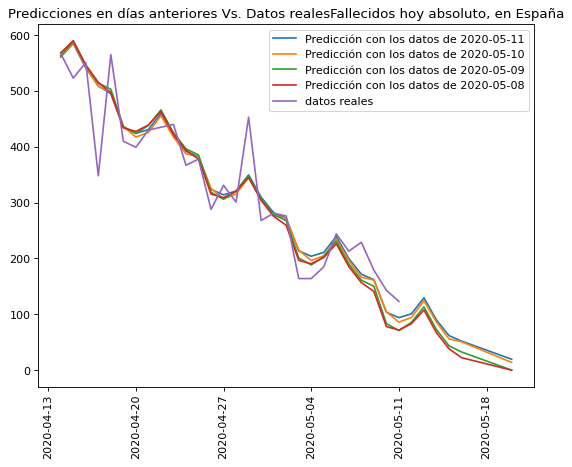

In [20]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'España'

link="Prediccion_Fallecidos_hoy_absoluto_España"


df = get_fallecidos_nacion()[['Total Fallecidos hoy absoluto']] 
df.columns = [ 'Fallecidos hoy absoluto' ]
df.sort_index(inplace=True,ascending=False)

prediccion = Get_Predictions_Compare( df = df, 
                                   dimension = dimension, 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR
                                   )
prediccion

In [21]:
MOVING_AVERAGE_WINDOW = 4
def report_single_location_single_dimension(location,dimension,window_size=MOVING_AVERAGE_WINDOW):
    
    Dimension = 'Fallecidos'
    labelMa = f'Moving Average ({window_size}) {dimension}'

    df = pd.DataFrame()
    df[dimension] = Get_Dimension_CCAA(dimension)[location]
    df[labelMa] = df[dimension].rolling(window=window_size).mean()

    display(HTML("<h2>Analisis de ''" + dimension +"'', en " + location + "</h2>"))
    fig = plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(df, marker='o') 
    plt.title("Gráfico de " + dimension +", en " + location)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))


    plt.legend(df.columns)
    fig.suptitle( dimension + ' in ' + location, fontsize=20)

    display(HTML(pd.DataFrame(df).to_html()))
    return  


### Casos totales españa, evolucion


,Fallecidos hoy absoluto,Moving Average (4) Fallecidos hoy absoluto
Fecha,,
2020-03-12,25,NaN
2020-03-13,25,NaN
2020-03-16,132,NaN
2020-03-17,142,81.00
2020-03-18,35,83.50
2020-03-19,108,104.25
2020-03-20,130,103.75
2020-03-21,176,112.25
2020-03-22,217,157.75


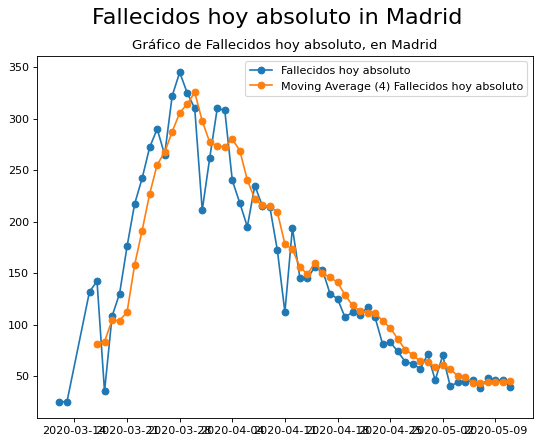

In [22]:

dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Madrid'

Insertar_Enlace("Reporte_Fallecidos_hoy_absoluto_Madrid")

report_single_location_single_dimension(COMUNIDAD_A_CONSIDERAR,dimension,4)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1,2020-03-09,3.273596,0.000000,44.547115,3.273596,3.273596,2.621683,2.621683,2.621683,2.621683,2.621683,2.621683,0.0,0.0,0.0,5.895279
2,2020-03-10,18.369880,0.000000,54.191517,18.369880,18.369880,-2.610647,-2.610647,-2.610647,-2.610647,-2.610647,-2.610647,0.0,0.0,0.0,15.759233
3,2020-03-11,33.466165,0.000000,62.712553,33.466165,33.466165,-8.448439,-8.448439,-8.448439,-8.448439,-8.448439,-8.448439,0.0,0.0,0.0,25.017726
4,2020-03-12,48.562449,12.562234,87.350633,48.562449,48.562449,2.158026,2.158026,2.158026,2.158026,2.158026,2.158026,0.0,0.0,0.0,50.720475
5,2020-03-13,63.658733,29.438453,107.461967,63.658733,63.658733,2.589343,2.589343,2.589343,2.589343,2.589343,2.589343,0.0,0.0,0.0,66.248076
6,2020-03-16,108.947586,71.968518,150.166050,108.947586,108.947586,2.621683,2.621683,2.621683,2.621683,2.621683,2.621683,0.0,0.0,0.0,111.569268
7,2020-03-17,124.043870,81.745997,159.719437,124.043870,124.043870,-2.610647,-2.610647,-2.610647,-2.610647,-2.610647,-2.610647,0.0,0.0,0.0,121.433222
8,2020-03-18,139.140154,91.035128,168.352253,139.140154,139.140154,-8.448439,-8.448439,-8.448439,-8.448439,-8.448439,-8.448439,0.0,0.0,0.0,130.691715
9,2020-03-19,154.236438,116.030885,193.526899,154.236438,154.236438,2.158026,2.158026,2.158026,2.158026,2.158026,2.158026,0.0,0.0,0.0,156.394463
10,2020-03-20,169.332722,133.180163,209.210784,169.332722,169.332722,2.589343,2.589343,2.589343,2.589343,2.589343,2.589343,0.0,0.0,0.0,171.922064


Prediccion total para Fallecidos hoy absoluto : 8730.605876086209


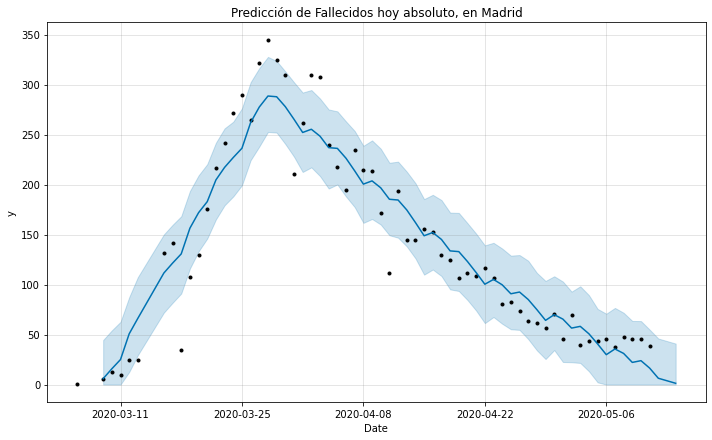

In [23]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Madrid'

link="Prediccion_Fallecidos_hoy_absoluto_Madrid"

prediccion = Get_Prediction_Nacion( df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR), 
                                   dimension = dimension, 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR
                                   )
                                 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Las predicciones del total de Fallecidos hoy absoluto en Madrid, cambian dia a dia
Predicción con los datos de 2020-05-11    3275.923611
Predicción con los datos de 2020-05-10    3247.188203
Predicción con los datos de 2020-05-09    3231.475332
Predicción con los datos de 2020-05-08    3168.236954
datos reales                              3097.000000
dtype: float64


,Predicción con los datos de 2020-05-11,Predicción con los datos de 2020-05-10,Predicción con los datos de 2020-05-09,Predicción con los datos de 2020-05-08,datos reales
ds,,,,,
2020-04-09,203.723090,202.942758,202.032919,202.871479,214.0
2020-04-10,196.776260,196.211422,196.229896,197.106545,172.0
2020-04-11,185.333523,186.933179,188.388248,183.518876,112.0
2020-04-12,184.595905,185.457172,183.481930,183.757125,194.0
2020-04-13,174.674370,172.061015,174.691949,175.003448,145.0
2020-04-14,162.064103,162.157816,165.456070,165.679536,145.0
2020-04-15,148.848405,149.143483,153.109512,153.244646,156.0
2020-04-16,152.076962,152.573908,157.211961,157.254142,153.0
2020-04-17,145.134391,145.843188,151.417252,151.489469,130.0


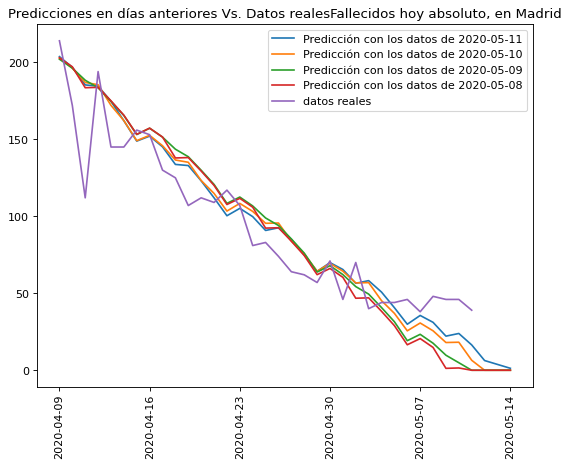

In [24]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Madrid'
link="Prediccion_Compare_Fallecidos_hoy_absoluto_Madrid"

df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)
prediccion = Get_Predictions_Compare( df = df, 
                                   dimension = dimension, 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR
                                   )
prediccion

,Fallecidos hoy absoluto,Moving Average (4) Fallecidos hoy absoluto
Fecha,,
2020-03-12,1,NaN
2020-03-13,0,NaN
2020-03-16,8,NaN
2020-03-17,6,3.75
2020-03-18,23,9.25
2020-03-19,14,12.75
2020-03-20,27,17.50
2020-03-21,40,26.00
2020-03-22,69,37.50


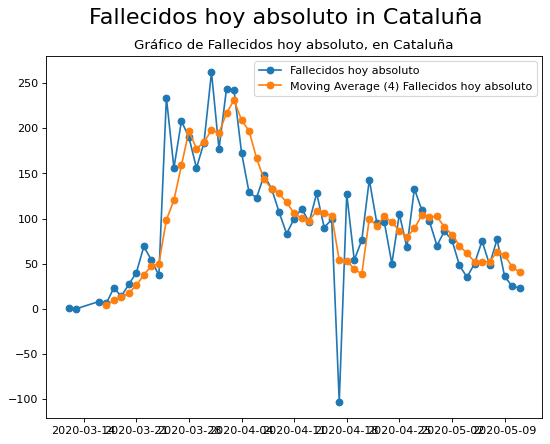

In [25]:

dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Cataluña'

Insertar_Enlace("Reporte_Fallecidos_hoy_absoluto_Cataluña")

report_single_location_single_dimension(COMUNIDAD_A_CONSIDERAR,dimension)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1,2020-03-10,-6.863978,0.000000,47.934316,-6.863978,-6.863978,7.084208,7.084208,7.084208,7.084208,7.084208,7.084208,0.0,0.0,0.0,0.220230
2,2020-03-12,9.355734,0.000000,58.565342,9.355734,9.355734,0.157602,0.157602,0.157602,0.157602,0.157602,0.157602,0.0,0.0,0.0,9.513336
3,2020-03-16,41.795157,0.000000,76.735321,41.795157,41.795157,-11.327940,-11.327940,-11.327940,-11.327940,-11.327940,-11.327940,0.0,0.0,0.0,30.467217
4,2020-03-17,49.905013,4.314874,102.562499,49.905013,49.905013,7.084208,7.084208,7.084208,7.084208,7.084208,7.084208,0.0,0.0,0.0,56.989221
5,2020-03-18,58.014869,21.873823,121.167581,58.014869,58.014869,12.167739,12.167739,12.167739,12.167739,12.167739,12.167739,0.0,0.0,0.0,70.182608
6,2020-03-19,66.124725,15.530736,114.151971,66.124725,66.124725,0.157602,0.157602,0.157602,0.157602,0.157602,0.157602,0.0,0.0,0.0,66.282327
7,2020-03-20,74.234581,35.025999,129.760374,74.234581,74.234581,8.945830,8.945830,8.945830,8.945830,8.945830,8.945830,0.0,0.0,0.0,83.180411
8,2020-03-21,82.344437,34.665216,136.010580,82.344437,82.344437,3.083389,3.083389,3.083389,3.083389,3.083389,3.083389,0.0,0.0,0.0,85.427825
9,2020-03-22,90.454292,17.659504,121.403968,90.454292,90.454292,-20.110828,-20.110828,-20.110828,-20.110828,-20.110828,-20.110828,0.0,0.0,0.0,70.343464
10,2020-03-23,98.564148,37.625782,133.978620,98.564148,98.564148,-11.327940,-11.327940,-11.327940,-11.327940,-11.327940,-11.327940,0.0,0.0,0.0,87.236209


Prediccion total para Fallecidos hoy absoluto : 5975.7627050756355


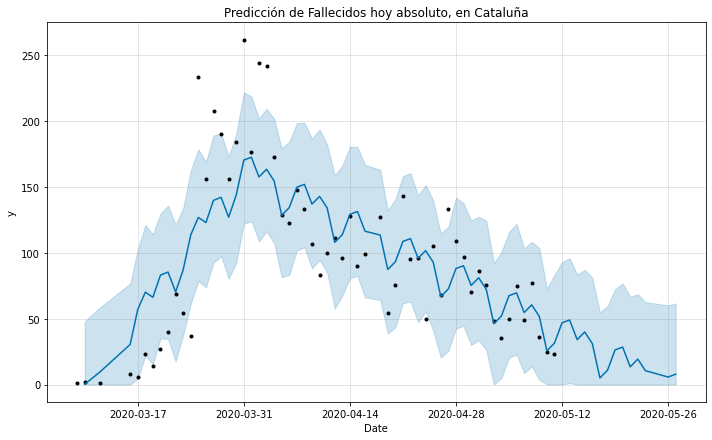

In [26]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Cataluña'
link="Prediccion_Fallecidos_hoy_absoluto_Cataluña"


prediccion = Get_Prediction_Nacion( df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR), 
                                   dimension = dimension, 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR)
                                 

,Fallecidos hoy absoluto,Moving Average (4) Fallecidos hoy absoluto
Fecha,,
2020-03-12,NaN,NaN
2020-03-13,1.0,NaN
2020-03-16,8.0,NaN
2020-03-17,3.0,NaN
2020-03-18,10.0,5.50
2020-03-19,7.0,7.00
2020-03-20,14.0,8.50
2020-03-21,12.0,10.75
2020-03-22,19.0,13.00


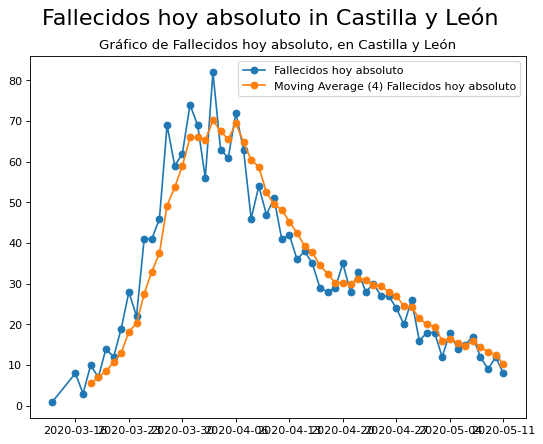

In [27]:
dimension = 'Fallecidos hoy absoluto'
report_single_location_single_dimension('Castilla y León',dimension)

Insertar_Enlace("Reporte_Fallecidos_hoy_absoluto_CyL")


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1,2020-03-16,2.267787,0.000000,12.777666,2.267787,2.267787,2.619379,2.619379,2.619379,2.619379,2.619379,2.619379,0.0,0.0,0.0,4.887166
2,2020-03-17,6.343463,0.000000,12.725331,6.343463,6.343463,-1.472445,-1.472445,-1.472445,-1.472445,-1.472445,-1.472445,0.0,0.0,0.0,4.871018
3,2020-03-18,10.419139,2.842671,19.198770,10.419139,10.419139,0.622328,0.622328,0.622328,0.622328,0.622328,0.622328,0.0,0.0,0.0,11.041467
4,2020-03-19,14.494815,4.203412,19.894976,14.494815,14.494815,-2.532993,-2.532993,-2.532993,-2.532993,-2.532993,-2.532993,0.0,0.0,0.0,11.961821
5,2020-03-20,18.570491,12.612715,28.053703,18.570491,18.570491,1.719192,1.719192,1.719192,1.719192,1.719192,1.719192,0.0,0.0,0.0,20.289683
6,2020-03-21,22.646167,15.207827,31.103467,22.646167,22.646167,0.536284,0.536284,0.536284,0.536284,0.536284,0.536284,0.0,0.0,0.0,23.182451
7,2020-03-22,26.721842,16.895448,33.011898,26.721842,26.721842,-1.491746,-1.491746,-1.491746,-1.491746,-1.491746,-1.491746,0.0,0.0,0.0,25.230097
8,2020-03-23,30.797518,25.722553,41.103951,30.797518,30.797518,2.619379,2.619379,2.619379,2.619379,2.619379,2.619379,0.0,0.0,0.0,33.416898
9,2020-03-24,34.873194,25.629754,41.197330,34.873194,34.873194,-1.472445,-1.472445,-1.472445,-1.472445,-1.472445,-1.472445,0.0,0.0,0.0,33.400749
10,2020-03-25,38.948870,32.021321,47.323500,38.948870,38.948870,0.622328,0.622328,0.622328,0.622328,0.622328,0.622328,0.0,0.0,0.0,39.571198


Prediccion total para Fallecidos hoy absoluto : 1923.2309157609545


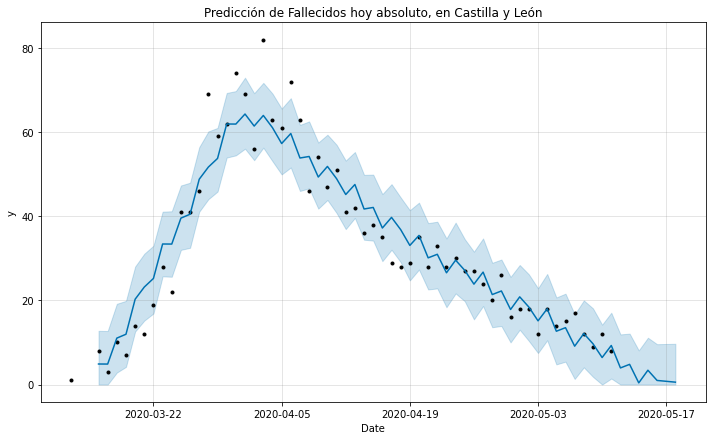

In [28]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Castilla y León'
link="Prediccion_Fallecidos_hoy_absoluto_CyL"

prediccion = Get_Prediction_Nacion( df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR), 
                                   dimension = dimension , 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR )
                                 
                                 

,Fallecidos hoy absoluto,Moving Average (4) Fallecidos hoy absoluto
Fecha,,
2020-03-12,1,NaN
2020-03-13,4,NaN
2020-03-16,12,NaN
2020-03-17,0,4.25
2020-03-18,11,6.75
2020-03-19,14,9.25
2020-03-20,20,11.25
2020-03-21,22,16.75
2020-03-22,28,21.00


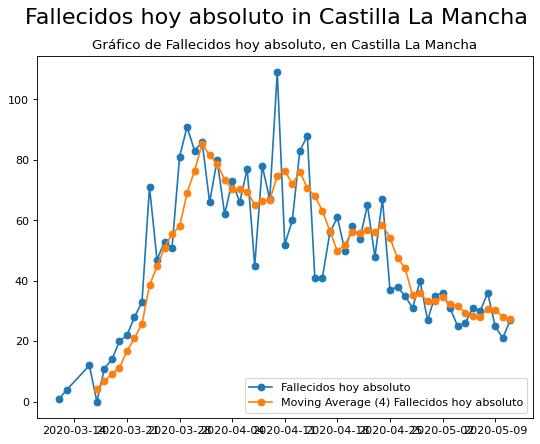

In [29]:
dimension = 'Fallecidos hoy absoluto'
report_single_location_single_dimension('Castilla La Mancha',dimension)
Insertar_Enlace("Reporte_Fallecidos_hoy_absoluto_CM")


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1,2020-03-13,4.160484,0.000000,22.910923,4.160484,4.160484,4.192989,4.192989,4.192989,4.192989,4.192989,4.192989,0.0,0.0,0.0,8.353473
2,2020-03-16,15.756316,2.303320,32.500185,15.756316,15.756316,2.005617,2.005617,2.005617,2.005617,2.005617,2.005617,0.0,0.0,0.0,17.761933
3,2020-03-18,23.486871,5.449477,35.922449,23.486871,23.486871,-2.295971,-2.295971,-2.295971,-2.295971,-2.295971,-2.295971,0.0,0.0,0.0,21.190900
4,2020-03-19,27.352148,9.275270,39.472165,27.352148,27.352148,-4.114603,-4.114603,-4.114603,-4.114603,-4.114603,-4.114603,0.0,0.0,0.0,23.237545
5,2020-03-20,31.217426,19.724462,49.773865,31.217426,31.217426,4.192989,4.192989,4.192989,4.192989,4.192989,4.192989,0.0,0.0,0.0,35.410415
6,2020-03-21,35.082703,18.371922,48.983101,35.082703,35.082703,-1.433641,-1.433641,-1.433641,-1.433641,-1.433641,-1.433641,0.0,0.0,0.0,33.649062
7,2020-03-22,38.947980,21.670210,51.374709,38.947980,38.947980,-1.729016,-1.729016,-1.729016,-1.729016,-1.729016,-1.729016,0.0,0.0,0.0,37.218964
8,2020-03-23,42.813258,29.366661,59.960679,42.813258,42.813258,2.005617,2.005617,2.005617,2.005617,2.005617,2.005617,0.0,0.0,0.0,44.818875
9,2020-03-24,46.678535,34.989660,66.225186,46.678535,46.678535,3.374624,3.374624,3.374624,3.374624,3.374624,3.374624,0.0,0.0,0.0,50.053159
10,2020-03-25,50.543812,33.008177,63.208791,50.543812,50.543812,-2.295971,-2.295971,-2.295971,-2.295971,-2.295971,-2.295971,0.0,0.0,0.0,48.247842


Prediccion total para Fallecidos hoy absoluto : 2971.9799836807183


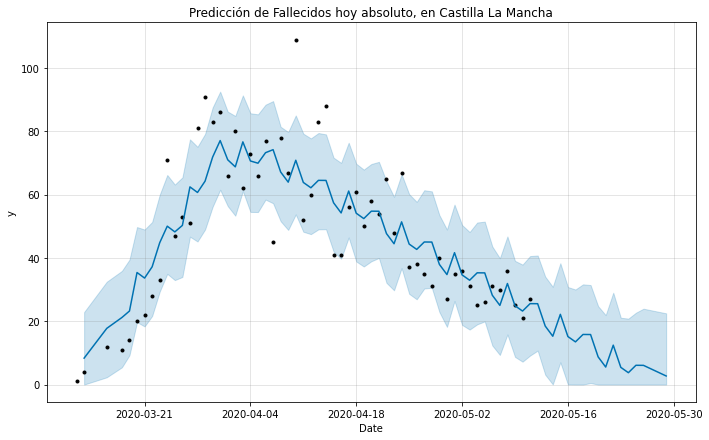

In [30]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Castilla La Mancha'
link="Prediccion_Fallecidos_hoy_absoluto_CM"

prediccion = Get_Prediction_Nacion( df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR), 
                                   dimension = dimension , 
                                   link = link,                                   
                                   location  = COMUNIDAD_A_CONSIDERAR )
                                 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Las predicciones del total de Fallecidos hoy absoluto en Castilla La Mancha, cambian dia a dia
Predicción con los datos de 2020-05-11    1359.835127
Predicción con los datos de 2020-05-10    1344.074894
Predicción con los datos de 2020-05-09    1360.632779
Predicción con los datos de 2020-05-08    1361.136681
datos reales                              1160.000000
dtype: float64


,Predicción con los datos de 2020-05-11,Predicción con los datos de 2020-05-10,Predicción con los datos de 2020-05-09,Predicción con los datos de 2020-05-08,datos reales
ds,,,,,
2020-04-14,64.511330,65.584277,65.957488,65.964872,88.0
2020-04-15,57.450140,58.462792,58.168245,58.177545,41.0
2020-04-16,54.240644,55.219893,54.044458,54.055529,41.0
2020-04-17,61.157001,62.046811,60.749419,60.760513,56.0
2020-04-18,54.139136,54.897474,54.503749,54.476296,61.0
2020-04-19,52.452233,53.125892,53.417275,53.428494,50.0
2020-04-20,54.795338,55.207615,55.121065,55.134017,58.0
2020-04-21,54.772816,55.324728,56.036672,56.048418,54.0
2020-04-22,47.710693,48.202412,48.246980,48.260236,65.0


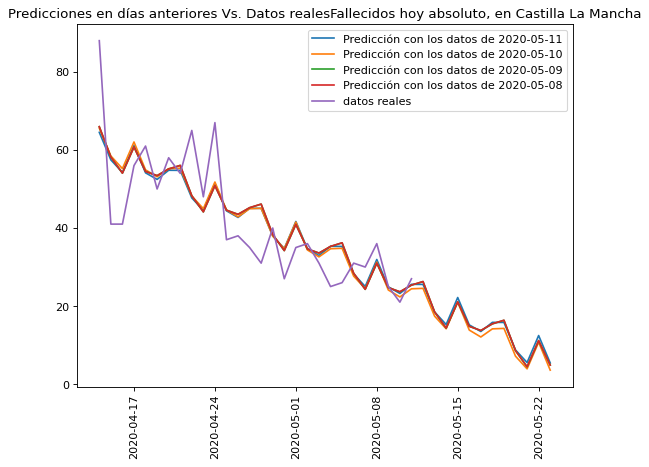

In [31]:
dimension = 'Fallecidos hoy absoluto'
COMUNIDAD_A_CONSIDERAR = 'Castilla La Mancha'
link="Prediccion_Compare_Fallecidos_hoy_absoluto_CM"

df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)
prediccion = Get_Predictions_Compare( df = df, 
                                   dimension = dimension, 
                                   link = link,
                                   location  = COMUNIDAD_A_CONSIDERAR
                                   )
prediccion

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-21,11350.432745,1670.910474,16819.452779,11350.432745,11350.432745,-1636.996623,-1636.996623,-1636.996623,-1636.996623,-1636.996623,-1636.996623,0.0,0.0,0.0,9713.436121
1,2020-03-22,11396.757752,1142.631877,16946.696918,11396.757752,11396.757752,-2242.728801,-2242.728801,-2242.728801,-2242.728801,-2242.728801,-2242.728801,0.0,0.0,0.0,9154.028951
2,2020-03-23,11443.082760,4773.494924,20403.432730,11443.082760,11443.082760,1351.971799,1351.971799,1351.971799,1351.971799,1351.971799,1351.971799,0.0,0.0,0.0,12795.054559
3,2020-03-24,11489.407767,5940.771737,21399.713855,11489.407767,11489.407767,1716.587380,1716.587380,1716.587380,1716.587380,1716.587380,1716.587380,0.0,0.0,0.0,13205.995147
4,2020-03-25,11535.732774,4968.288285,20617.602040,11535.732774,11535.732774,969.331626,969.331626,969.331626,969.331626,969.331626,969.331626,0.0,0.0,0.0,12505.064400
5,2020-03-26,11582.057781,4604.627236,19803.443502,11582.057781,11582.057781,291.289652,291.289652,291.289652,291.289652,291.289652,291.289652,0.0,0.0,0.0,11873.347433
6,2020-03-27,11628.382789,2697.710400,19199.701373,11628.382789,11628.382789,-449.455031,-449.455031,-449.455031,-449.455031,-449.455031,-449.455031,0.0,0.0,0.0,11178.927758
7,2020-03-28,11674.707796,2738.964837,18399.253422,11674.707796,11674.707796,-1636.996623,-1636.996623,-1636.996623,-1636.996623,-1636.996623,-1636.996623,0.0,0.0,0.0,10037.711173
8,2020-03-29,11721.032803,1642.318514,17290.197541,11721.032803,11721.032803,-2242.728801,-2242.728801,-2242.728801,-2242.728801,-2242.728801,-2242.728801,0.0,0.0,0.0,9478.304002
9,2020-03-30,11767.357811,4877.407737,20679.371148,11767.357811,11767.357811,1351.971799,1351.971799,1351.971799,1351.971799,1351.971799,1351.971799,0.0,0.0,0.0,13119.329610


Prediccion total para Hospitalizados : 4857370.826555552


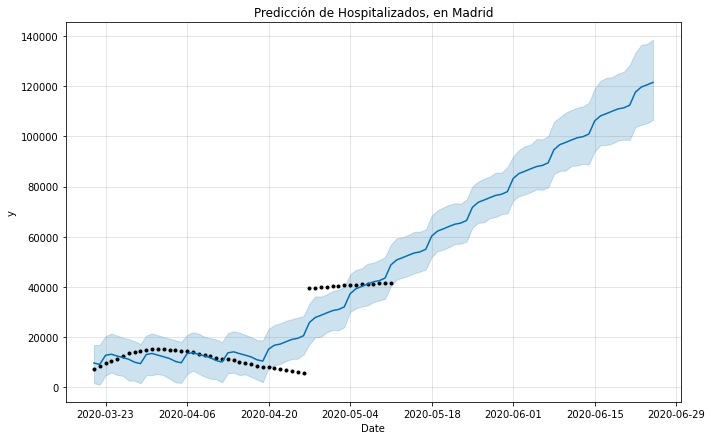

In [32]:
dimension = 'Hospitalizados'
COMUNIDAD_A_CONSIDERAR = 'Madrid'
link="Prediccion_Hospitalizados_Madrid"

prediccion = Get_Prediction_Nacion( df = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR), 
                                   dimension = dimension , 
                                   link = link,                                   
                                   location  = COMUNIDAD_A_CONSIDERAR )

,Proporcion Curados hoy absoluto / Casos hoy absoluto,Moving Average (4) Proporcion Curados hoy absoluto / Casos hoy absoluto
Fecha,,
2020-03-12,0.000000,NaN
2020-03-13,0.000000,NaN
2020-03-16,0.000000,NaN
2020-03-17,0.000000,0.000000
2020-03-18,0.000000,0.000000
2020-03-19,0.000000,0.000000
2020-03-20,0.000000,0.000000
2020-03-21,0.000000,0.000000
2020-03-22,0.000000,0.000000


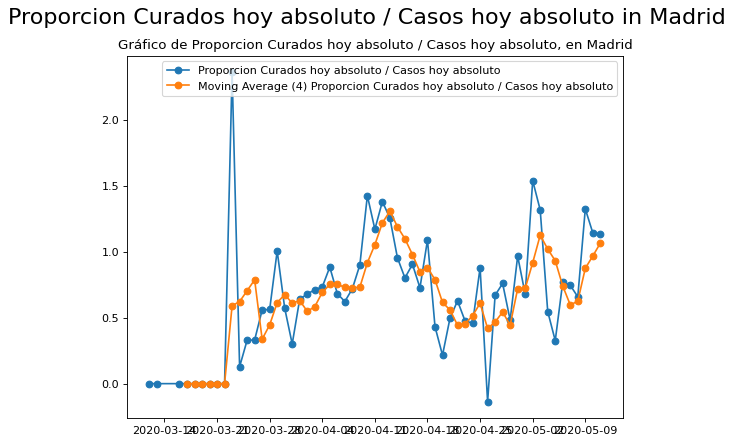

In [33]:
dimension = 'Proporcion Curados hoy absoluto / Casos hoy absoluto'
report_single_location_single_dimension('Madrid',dimension)


# ¿ Son reales estas cifras ? 
 
 Según reportaje de el mundo :https://www.elmundo.es/madrid/2020/04/07/5e8c427d21efa0b1668b45d6.html
 
   Entre los días 15 y 31 de marzo fallecieron en Madrid capital, "por todas las causas", aunque la mayoría por coronavirus, 5.950 personas, cuando en 2019, en el mismo lapso, murieron 1.100 personas

In [34]:
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

COMUNIDAD_A_CONSIDERAR = 'Madrid'
comunidad = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)

Insertar_Enlace("Reales")

comunidad.head(24).tail(15)['Fallecidos hoy absoluto'].sum()
comunidad['Fecha'] = comunidad.index

date1 = datetime.strptime('2020-03-15', '%Y-%m-%d')
date2 = datetime.strptime('2020-04-01', '%Y-%m-%d')

madrid_muertos_segun_sanidad = comunidad.loc[(comunidad['Fecha']>date1) & (comunidad['Fecha']<date2)]['Fallecidos hoy absoluto'].sum()

display(HTML ("Madrid muertos segun, <b>sanidad</b>, segunda quincena de Marzo:  <b>" + str(madrid_muertos_segun_sanidad)+"</b>"))

##

madrid_muertos_segun_interior = 5950 - 1100


display(HTML ("Madrid muertos segun, <b>interior</b>, mismo intervalo: <b>" + str(madrid_muertos_segun_interior)+"</b>"))


porcentaje_error = (madrid_muertos_segun_interior - madrid_muertos_segun_sanidad) / madrid_muertos_segun_sanidad


display(HTML ("La diferencia porcentual entre los muertos de sanidad e interior es de  <b>" + str(porcentaje_error) + "</b>") )

prediccion_muertos = comunidad['Fallecidos hoy absoluto'].sum()* (1+porcentaje_error)



display(HTML ("El numero de <b>fallecidos en Madrid</b>, hasta ahora es de <b>" + str(comunidad['Fallecidos hoy absoluto'].sum()) +
         "</b>, pero con el incremento del <b>" + str(porcentaje_error) +
         "</b> ,la cifra real sería de : <b>" + str(  int(prediccion_muertos)) + "</b> muertos" 
                                           ) )
Dimension = 'Fallecidos hoy absoluto'
df = Get_Dimension_CCAA(Dimension)

df['Total Fallecidos'] = df.sum(axis=1)

total_muertos_españa = int(df['Total Fallecidos'].sum())
prediccion_muertos_españa = total_muertos_españa* (1+porcentaje_error)

display(HTML ("El numero de <b>fallecidos en España</b>, hasta ahora es de <b>" + str(total_muertos_españa) +
         "</b>, pero con el incremento del <b>" + str(porcentaje_error) +
         "</b> ,la cifra real sería de : <b>" + str(  int(prediccion_muertos_españa)) + "</b> muertos"
                                           ))

In [35]:
from datetime import datetime

COMUNIDAD_A_CONSIDERAR = 'Madrid'
#comunidad = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)


comunidad.head(24).tail(15)['Fallecidos hoy absoluto'].sum()
comunidad['Fecha'] = comunidad.index

date1 = datetime.strptime('2020-03-15', '%Y-%m-%d')
date2 = datetime.strptime('2020-04-01', '%Y-%m-%d')

comunidad.loc[(comunidad['Fecha']>date1) & (comunidad['Fecha']<date2)]['Fallecidos hoy absoluto'].sum()

3522

Text(0.5, 1.0, 'Diferencia entre las cifras de muertos\n para Madrid y España\n entre los ministerios de Sanidad e Interior')

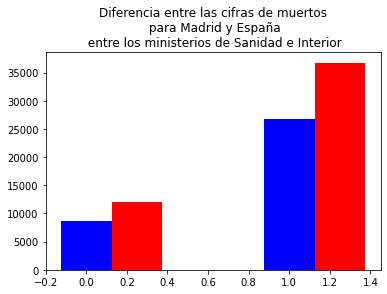

In [36]:
y = [comunidad['Fallecidos hoy absoluto'].sum(),total_muertos_españa]
z = [comunidad['Fallecidos hoy absoluto'].sum()* (1+porcentaje_error), total_muertos_españa* (1+porcentaje_error)]

X = np.arange(2)

ax=plt.subplot(111)
plt.bar(X+0, y,color = 'b', width = 0.25)
plt.bar(X+0.25, z,color = 'r', width = 0.25)


ax.set_title("Diferencia entre las cifras de muertos\n para Madrid y España\n entre los ministerios de Sanidad e Interior")
